In [61]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [62]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0594_FO_IMA_07018938_FORF253_CAL_0048-0075_Field_Y.fits'

#Name of field
field='FieldY'

#wavelength of data
wavelength=25.2

In [63]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

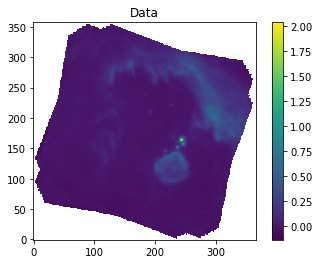

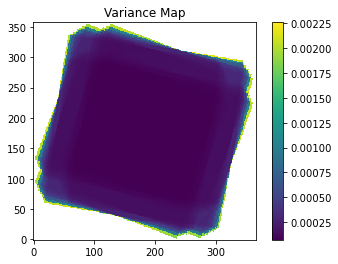

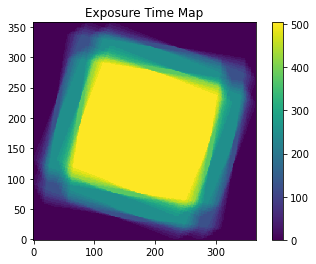

In [64]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

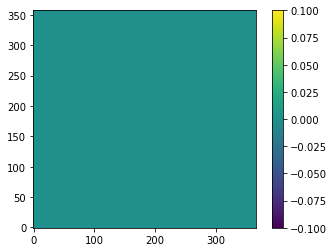

In [65]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[0:40,0:340]=1
#mask2[0:100,300:340]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [66]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

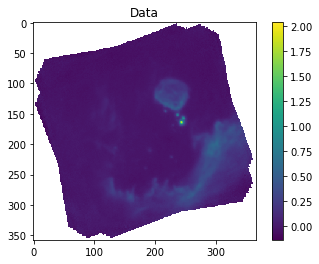

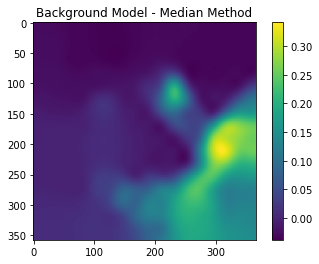

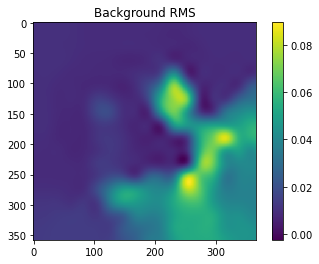

In [67]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [68]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

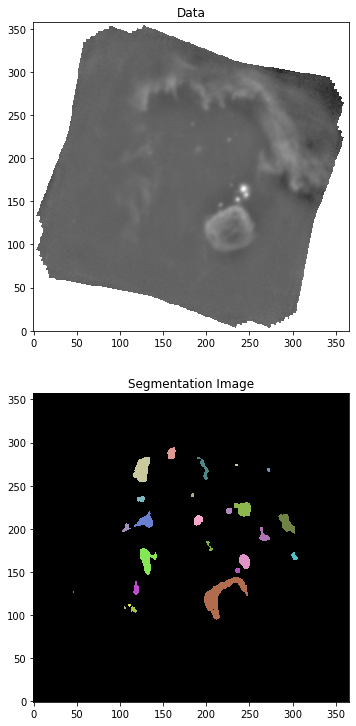

In [69]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [70]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,219.18220859034523,126.48348348807781,"266.5655229783682,-28.833378137783274",0.008540983899789958,0.09140518570335246,73.30695893408867,802.0,16.83032441480354,7.6929016693597605,36.14963643431714,0.008181763766647357,-0.01273423410487478,0.012245954340992115,0.889422624886624,0.5429142374348248,2.187773240601454,30.81309500210232,232.26623114800918,nan,0.7586294798667259,193.8518072610894,nan
2,115.88593498722192,106.35964400421261,"266.5906789921324,-28.83766953877255",-0.005869770749542169,-0.017382367366785886,-0.6431475925710778,37.0,2.0788388406235385,1.4767824243306142,-35.643868690312324,0.30852952328374095,0.21512601783081253,0.3813969836631897,0.7038101399628705,0.2896118758837217,1.4076811901156125,4.246014560685715,8.430079130028417,nan,3.4432538327564917,1.1647025261991453,nan
3,105.87941860510048,108.74081368817603,"266.5931158015725,-28.837161144899962",-0.019235879692962483,-0.01663251577480088,-0.11642761042360616,7.0,0.9285510271558792,0.6133244597759124,-36.118605652537646,1.680513306628487,1.4271395017649176,2.1376954722056154,0.7508104068242623,0.3394822235515642,1.5139637957617729,1.8529709974391715,2.803366104919945,nan,3.715938299896071,0.21885070277396992,nan
4,111.45383289588463,111.81790331906105,"266.5917581054323,-28.836504933642054",-0.011251727514043734,-0.010743984727390946,-0.1181838320013004,11.0,1.1193399231700072,0.7419137873616511,41.33411334246556,1.2424433035911084,-1.0102787374145248,1.3724324781066042,0.7487843860115578,0.3371863434831065,1.508719668292641,2.236061238647513,5.630664884810658,nan,3.8802981118320057,0.3766166040118652,nan
5,119.19920226883134,130.7499637584879,"266.5898710569407,-28.832466397779356",-0.002657970667343593,0.015245671369478178,1.1891623668192979,78.0,3.856230864857478,1.5898928255469909,-89.38816282502103,0.39556986149697004,0.007012302541307685,0.06728460203410631,0.9110517949401878,0.5877080804378263,2.4254659200256286,6.945377091004253,21.770696671016996,nan,3.124484257764255,4.709250479209507,nan
6,46.502780869276386,126.86185768744133,"266.60757452781826,-28.833291983119647",-0.03707106304662172,-0.018702176413754937,-0.11221305848252963,6.0,0.7491369914354818,0.4975536012946498,-84.94748205066516,4.021921671014466,0.3960954443129097,1.7993860176368603,0.7475824219977537,0.33583095350658465,1.5056407781718477,1.4974561717099848,0.6772421386177491,nan,2.9338921110904375,0.2501251516785939,nan
7,131.29644805505646,162.833799988331,"266.58692393653223,-28.825622267480064",-0.012742933629343011,0.0075961833026005855,2.423182473529587,319.0,7.597759698022442,3.8742973505547282,-84.22592733697846,0.06612247695830792,0.009869074665515107,0.01782220697489576,0.8602181045723394,0.4900737184984757,1.9610677783765313,14.200964064535068,49.61581525953855,nan,2.760334402638087,19.37279830033659,nan
8,236.69378863025375,151.89608481280095,"266.5612588925063,-28.82795660605341",0.00042922948393141013,0.07692596823660716,2.461630983571429,32.0,1.4071450232261038,1.3633352345974987,89.34972748321984,0.538011121357541,-0.0007485290325801296,0.5050401843085066,0.24758495466438588,0.031133812013323325,1.0321342744739808,3.2623990327154755,22.82820019922581,nan,2.458644204194846,12.786387698431593,nan


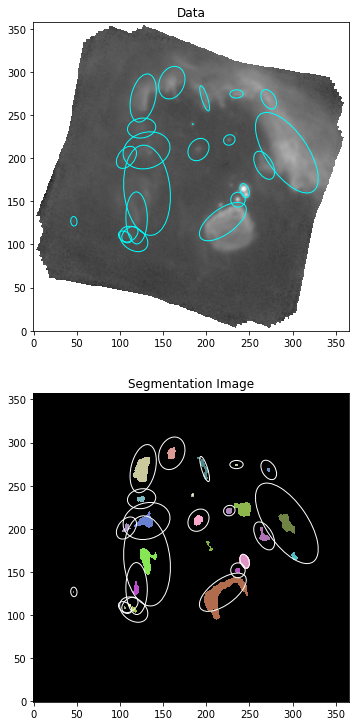

In [71]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

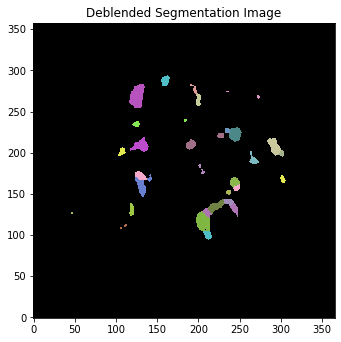

In [72]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [73]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,115.88593498722192,106.35964400421261,"266.5906789921324,-28.83766953877255",-0.005869770749542169,-0.017382367366785886,-0.6431475925710778,37.0,2.0788388406235385,1.4767824243306142,-35.643868690312324,0.30852952328374095,0.21512601783081253,0.3813969836631897,0.7038101399628705,0.2896118758837217,1.4076811901156125,4.246014560685715,8.430079130028417,nan,3.4432538327564917,1.1647025261991453,nan
2,105.87941860510048,108.74081368817603,"266.5931158015725,-28.837161144899962",-0.019235879692962483,-0.01663251577480088,-0.11642761042360616,7.0,0.9285510271558792,0.6133244597759124,-36.118605652537646,1.680513306628487,1.4271395017649176,2.1376954722056154,0.7508104068242623,0.3394822235515642,1.5139637957617729,1.8529709974391715,2.803366104919945,nan,3.715938299896071,0.21885070277396992,nan
3,111.45383289588463,111.81790331906105,"266.5917581054323,-28.836504933642054",-0.011251727514043734,-0.010743984727390946,-0.1181838320013004,11.0,1.1193399231700072,0.7419137873616511,41.33411334246556,1.2424433035911084,-1.0102787374145248,1.3724324781066042,0.7487843860115578,0.3371863434831065,1.508719668292641,2.236061238647513,5.630664884810658,nan,3.8802981118320057,0.3766166040118652,nan
4,119.19920226883134,130.7499637584879,"266.5898710569407,-28.832466397779356",-0.002657970667343593,0.015245671369478178,1.1891623668192979,78.0,3.856230864857478,1.5898928255469909,-89.38816282502103,0.39556986149697004,0.007012302541307685,0.06728460203410631,0.9110517949401878,0.5877080804378263,2.4254659200256286,6.945377091004253,21.770696671016996,nan,3.124484257764255,4.709250479209507,nan
5,46.502780869276386,126.86185768744133,"266.60757452781826,-28.833291983119647",-0.03707106304662172,-0.018702176413754937,-0.11221305848252963,6.0,0.7491369914354818,0.4975536012946498,-84.94748205066516,4.021921671014466,0.3960954443129097,1.7993860176368603,0.7475824219977537,0.33583095350658465,1.5056407781718477,1.4974561717099848,0.6772421386177491,nan,2.9338921110904375,0.2501251516785939,nan
6,236.69378863025375,151.89608481280095,"266.5612588925063,-28.82795660605341",0.00042922948393141013,0.07692596823660716,2.461630983571429,32.0,1.4071450232261038,1.3633352345974987,89.34972748321984,0.538011121357541,-0.0007485290325801296,0.5050401843085066,0.24758495466438588,0.031133812013323325,1.0321342744739808,3.2623990327154755,22.82820019922581,nan,2.458644204194846,12.786387698431593,nan
7,302.33859653078224,168.06740282420276,"266.54527442653125,-28.824504868443228",0.08520074530245546,0.19187259570926138,9.209884594044546,48.0,2.6628412529307783,1.4012216598148324,-61.75040150253256,0.4268094213826373,0.30710520114564516,0.2235347332181921,0.8503528022414691,0.4737870091682639,1.900371175594492,5.010331545618104,nan,nan,nan,9.251748343148371,nan
8,107.43993649626904,200.9277279210663,"266.5927312859176,-28.817494672388804",0.025645931388548586,0.008953810835408998,0.4924595959474949,55.0,2.7029865186802,1.766816179572064,51.664982478360386,0.24975854643247114,-0.17853018454919273,0.20745720047036542,0.7567940965013458,0.3463466549456725,1.5298628968492258,5.376981759280604,5.786012890314553,nan,2.145467180523501,2.32571549639202,nan


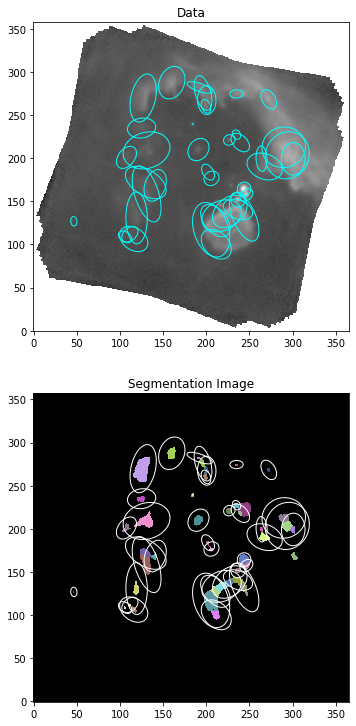

In [74]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [75]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [76]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [77]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,115.88593498722192,106.35964400421261,"266.5906789921324,-28.83766953877255",-0.005869770749542169,-0.017382367366785886,-0.6431475925710778,37.0,2.0788388406235385,1.4767824243306142,-35.643868690312324,0.30852952328374095,0.21512601783081253,0.3813969836631897,0.7038101399628705,0.2896118758837217,1.4076811901156125,4.246014560685715,8.430079130028417,0.2391570019657385,3.4432538327564917,1.1647025261991453,0.053555373,-0.01696668276338888,-0.017272729151089072,0.00254067820704066,5.032844275536146
2,105.87941860510048,108.74081368817603,"266.5931158015725,-28.837161144899962",-0.019235879692962483,-0.01663251577480088,-0.11642761042360616,7.0,0.9285510271558792,0.6133244597759124,-36.118605652537646,1.680513306628487,1.4271395017649176,2.1376954722056154,0.7508104068242623,0.3394822235515642,1.5139637957617729,1.8529709974391715,2.803366104919945,0.11047772904519815,3.715938299896071,0.21885070277396992,0.023338124,-0.016223637763251333,-0.016249217931482086,0.001057145268128065,1.4325670985941563
3,111.45383289588463,111.81790331906105,"266.5917581054323,-28.836504933642054",-0.011251727514043734,-0.010743984727390946,-0.1181838320013004,11.0,1.1193399231700072,0.7419137873616511,41.33411334246556,1.2424433035911084,-1.0102787374145248,1.3724324781066042,0.7487843860115578,0.3371863434831065,1.508719668292641,2.236061238647513,5.630664884810658,0.1386617422658037,3.8802981118320057,0.3766166040118652,0.02931286,-0.011230352771789933,-0.011279932197403704,0.001770668915367157,2.1997349975644243
4,119.19920226883134,130.7499637584879,"266.5898710569407,-28.832466397779356",-0.002657970667343593,0.015245671369478178,1.1891623668192979,78.0,3.856230864857478,1.5898928255469909,-89.38816282502103,0.39556986149697004,0.007012302541307685,0.06728460203410631,0.9110517949401878,0.5877080804378263,2.4254659200256286,6.945377091004253,21.770696671016996,0.30198500776273074,3.124484257764255,4.709250479209507,0.07791305,0.015527360984054267,0.016469440180281562,0.002897604330388705,4.034399038329361
5,46.502780869276386,126.86185768744133,"266.60757452781826,-28.833291983119647",-0.03707106304662172,-0.018702176413754937,-0.11221305848252963,6.0,0.7491369914354818,0.4975536012946498,-84.94748205066516,4.021921671014466,0.3960954443129097,1.7993860176368603,0.7475824219977537,0.33583095350658465,1.5056407781718477,1.4974561717099848,0.6772421386177491,0.09722955962274256,2.9338921110904375,0.2501251516785939,0.029513637,-0.018702176413754937,-0.018702516729817265,0.00021158316410246398,1.455948462734545
6,236.69378863025375,151.89608481280095,"266.5612588925063,-28.82795660605341",0.00042922948393141013,0.07692596823660716,2.461630983571429,32.0,1.4071450232261038,1.3633352345974987,89.34972748321984,0.538011121357541,-0.0007485290325801296,0.5050401843085066,0.24758495466438588,0.031133812013323325,1.0321342744739808,3.2623990327154755,22.82820019922581,0.13098533270039803,2.458644204194846,12.786387698431593,0.049344875,0.07694352927149979,0.07649138227168265,0.00547986185528878,8.091566127481517
7,302.33859653078224,168.06740282420276,"266.54527442653125,-28.824504868443228",0.08520074530245546,0.19187259570926138,9.209884594044546,48.0,2.6628412529307783,1.4012216598148324,-61.75040150253256,0.4268094213826373,0.30710520114564516,0.2235347332181921,0.8503528022414691,0.4737870091682639,1.900371175594492,5.010331545618104,nan,nan,nan,9.

In [78]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [79]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,115.88593498725885,106.35964400416954,"266.5906789921324,-28.83766953877255",0.6822395946859359,0.04064133865331794,2.2260257009237066,0.08148632016770443,4.100797487733516,0.12267068691644782,5.86203011406568,0.1642320069988679,7.686243315531719,0.20629069978219072
2,105.87941860512889,108.74081368820679,"266.5931158015725,-28.837161144899962",0.6141349611790835,0.04079225082964179,1.9633921480580698,0.0819007104922676,3.7530301872417233,0.12338091834727447,5.691515981713288,0.1651863142762989,7.110999498013976,0.20738746536677527
3,111.45383289597534,111.81790331907138,"266.5917581054323,-28.836504933642054",0.6640402980828792,0.040786680229194176,2.406567268528535,0.08151197073389997,5.001288613899734,0.12231034785597818,7.367104043958591,0.16336384337222304,9.128054379066237,0.2047749566888347
4,119.19920226876583,130.74996375847985,"266.5898710569407,-28.832466397779356",1.4030615903885035,0.040715773587440496,4.647451486560291,0.08146012637770397,7.679695786322432,0.12217780166090446,10.0073110822037,0.16289091473874537,12.096161046500237,0.2035801568143821
5,46.50278086932232,126.86185768748179,"266.60757452781826,-28.833291983119647",0.48789722413535846,0.056454540582658176,0.7127891222704755,0.11265123432324477,0.7794011506701453,0.1674254812484284,0.8990074780439337,0.2217345264065408,0.6082482233944615,0.27569310842683104
6,236.69378863026864,151.8960848128333,"266.5612588925063,-28.82795660605341",10.284265965035557,0.04026989758935169,17.47690103053513,0.08046755042590435,22.868965410331892,0.12066420376499686,40.469701829850976,0.16082326529791785,76.96922440533095,0.2010214277467998
7,302.33859653083715,168.06740282418605,"266.54527442653125,-28.824504868443228",4.30163505059049,0.05613825752799675,13.125970377845414,0.11163503022648866,17.67253769959372,0.16579767293797312,14.871883265174096,0.2188700139254299,7.1955779465983305,0.27135966193392025
8,107.43993649593516,200.92772792109932,"266.5927312859176,-28.817494672388804",0.9606943129581627,0.04033582087744722,2.9906445109444575,0.0806914279788232,4.7987111492556425,0.12105232228533894,5.596873068710095,0.16144321931660513,5.164035927161749,0.20182613539839864


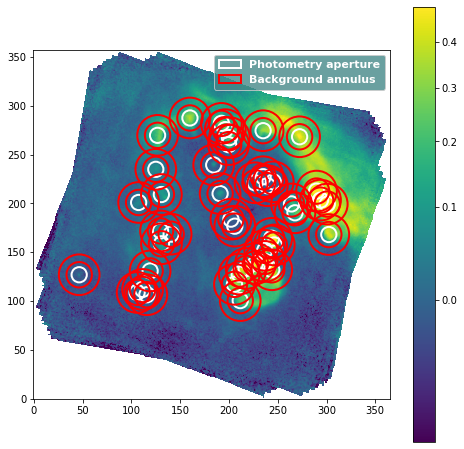

In [80]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [81]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [82]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-82-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,115.88593498725885,106.35964400416954,"266.5906789921324,-28.83766953877255",4.100797487733516,0.12267068691644782,0.0011752022821559464,0.0022560072931587876,3.875455276296145,0.12267068691644782,0.0011752022821559466,5.9215683156859305
2,105.87941860512889,108.74081368820679,"266.5931158015725,-28.837161144899962",3.7530301872417233,0.12338091834727447,0.00026573616429141975,0.001002479361754458,3.7020759167901223,0.12338091834727447,0.0002657361642914197,7.992165655019999
3,111.45383289597534,111.81790331907138,"266.5917581054323,-28.836504933642054",5.001288613899734,0.12231034785597818,-0.0005025185741436495,-0.0009303891907661726,5.097645342018186,0.12231034785597818,0.0,13.138618463962773
4,119.19920226876583,130.74996375847985,"266.5898710569407,-28.832466397779356",7.679695786322432,0.12217780166090446,0.0008020841622448103,0.004383386224654648,7.525898077091,0.12217780166090446,0.0008020841622448103,12.913225772597922
5,46.50278086932232,126.86185768748179,"266.60757452781826,-28.833291983119647",0.7794011506701453,0.1674254812484284,3.028070225483808e-05,0.00033424667385599467,0.7735948988328327,0.1674254812484284,3.0280702254838073e-05,1.6753731729530834
6,236.69378863026864,151.8960848128333,"266.5612588925063,-28.82795660605341",22.868965410331892,0.12066420376499686,-0.0017158851508229853,0.05188301811260627,23.197982261583793,0.12066420376499686,0.0,60.1966982477336
7,302.33859653083715,168.06740282418605,"266.54527442653125,-28.824504868443228",17.67253769959372,0.16579767293797312,-0.037811044775308944,-0.029510595899201075,24.922714605985163,0.16579767293797312,0.0,55.17188392244251
8,107.43993649593516,200.92772792109932,"266.5927312859176,-28.817494672388804",4.7987111492556425,0.12105232228533894,-0.005059124518389086,-0.005020835640972647,5.768786109303704,0.12105232228533894,0.0,14.945469373423947


In [83]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [84]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,115.88593498722192,106.35964400421261,"266.5906789921324,-28.83766953877255",-0.005869770749542169,-0.017382367366785886,-0.6431475925710778,37.0,2.0788388406235385,1.4767824243306142,-35.643868690312324,0.30852952328374095,0.21512601783081253,0.3813969836631897,0.7038101399628705,0.2896118758837217,1.4076811901156125,4.246014560685715,8.430079130028417,0.2391570019657385,3.4432538327564917,1.1647025261991453,0.053555373,-0.01696668276338888,-0.017272729151089072,0.00254067820704066,5.032844275536146,0.6822395946859359,0.04064133865331794,2.2260257009237066,0.08148632016770443,4.100797487733516,0.12267068691644782,5.86203011406568,0.1642320069988679,7.686243315531719,0.20629069978219072,0.0011752022821559464,0.0022560072931587876,3.875455276296145,0.12267068691644782,0.0011752022821559466,5.9215683156859305,0.6572015711928947,2.125873606951542,5.461421738177022,7.060292728205689,2.5321325596253685,4.750416241774629,6.119188109473029,6.0414390131468,6.119188109473029,C7FieldY,25.2
2,105.87941860510048,108.74081368817603,"266.5931158015725,-28.837161144899962",-0.019235879692962483,-0.01663251577480088,-0.11642761042360616,7.0,0.9285510271558792,0.6133244597759124,-36.118605652537646,1.680513306628487,1.4271395017649176,2.1376954722056154,0.7508104068242623,0.3394822235515642,1.5139637957617729,1.8529709974391715,2.803366104919945,0.11047772904519815,3.715938299896071,0.21885070277396992,0.023338124,-0.016223637763251333,-0.016249217931482086,0.001057145268128065,1.4325670985941563,0.6141349611790835,0.04079225082964179,1.9633921480580698,0.0819007104922676,3.7530301872417233,0.12338091834727447,5.691515981713288,0.1651863142762989,7.110999498013976,0.20738746536677527,0.00026573616429141975,0.001002479361754458,3.7020759167901223,0.12338091834727447,0.0002657361642914197,7.992165655019999,0.60847337557335,1.9407458056351359,5.6009306120215525,6.969459857870639,2.7876169371994033,5.7162449995066975,9.32577471163027,9.210306516365138,9.32577471163027,C7FieldY,25.2
3,111.45383289588463,111.81790331906105,"266.5917581054323,-28.836504933642054",-0.011251727514043734,-0.010743984727390946,-0.1181838320013004,11.0,1.1193399231700072,0.7419137873616511,41.33411334246556,1.2424433035911084,-1.0102787374145248,1.3724324781066042,0.7487843860115578,0.3371863434831065,1.508719668292641,2.236061238647513,5.630664884810658,0.1386617422658037,3.8802981118320057,0.3766166040118652,0.02931286,-0.011230352771789933,-0.011279932197403704,0.001770668915367157,2.1997349975644243,0.6640402980828792,0.040786680229194176,2.406567268528535,0.08151197073389997,5.001288613899734,0.12231034785597818,7.367104043958591,0.16336384337222304,9.128054379066237,0.2047749566888347,-0.0005025185741436

In [85]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [86]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,115.88593498722192,106.35964400421261,"266.5906789921324,-28.83766953877255",-0.005869770749542169,-0.017382367366785886,-0.6431475925710778,37.0,2.0788388406235385,1.4767824243306142,-35.643868690312324,0.30852952328374095,0.21512601783081253,0.3813969836631897,0.7038101399628705,0.2896118758837217,1.4076811901156125,4.246014560685715,8.430079130028417,0.2391570019657385,3.4432538327564917,1.1647025261991453,0.053555373,-0.01696668276338888,-0.017272729151089072,0.00254067820704066,5.032844275536146,0.6822395946859359,0.04064133865331794,2.2260257009237066,0.08148632016770443,4.100797487733516,0.12267068691644782,5.86203011406568,0.1642320069988679,7.686243315531719,0.20629069978219072,0.0011752022821559464,0.0022560072931587876,3.875455276296145,0.12267068691644782,0.0011752022821559466,5.9215683156859305,0.6572015711928947,2.125873606951542,5.461421738177022,7.060292728205689,2.5321325596253685,4.750416241774629,6.119188109473029,6.0414390131468,6.119188109473029,C7FieldY,25.2
4,119.19920226883134,130.7499637584879,"266.5898710569407,-28.832466397779356",-0.002657970667343593,0.015245671369478178,1.1891623668192979,78.0,3.856230864857478,1.5898928255469909,-89.38816282502103,0.39556986149697004,0.007012302541307685,0.06728460203410631,0.9110517949401878,0.5877080804378263,2.4254659200256286,6.945377091004253,21.770696671016996,0.30198500776273074,3.124484257764255,4.709250479209507,0.07791305,0.015527360984054267,0.016469440180281562,0.002897604330388705,4.034399038329361,1.4030615903885035,0.040715773587440496,4.647451486560291,0.08146012637770397,7.679695786322432,0.12217780166090446,10.0073110822037,0.16289091473874537,12.096161046500237,0.2035801568143821,0.0008020841622448103,0.004383386224654648,7.525898077091,0.12217780166090446,0.0008020841622448103,12.913225772597922,1.3859729560294554,4.579096949124098,9.73389293245893,11.668945187524034,5.6921532659605285,11.266804336120204,12.409103470425226,11.469102803531506,12.913225772597922,C7FieldY,25.2
6,236.69378863025375,151.89608481280095,"266.5612588925063,-28.82795660605341",0.00042922948393141013,0.07692596823660716,2.461630983571429,32.0,1.4071450232261038,1.3633352345974987,89.34972748321984,0.538011121357541,-0.0007485290325801296,0.5050401843085066,0.24758495466438588,0.031133812013323325,1.0321342744739808,3.2623990327154755,22.82820019922581,0.13098533270039803,2.458644204194846,12.786387698431593,0.049344875,0.07694352927149979,0.07649138227168265,0.00547986185528878,8.091566127481517,10.284265965035557,0.04026989758935169,17.47690103053513,0.08046755042590435,22.868965410331892,0.12066420376499686,40.469701829850976,0.16082326529791785,76.96922440533095,0.2010214277467998,-0.0017158851508229853,0

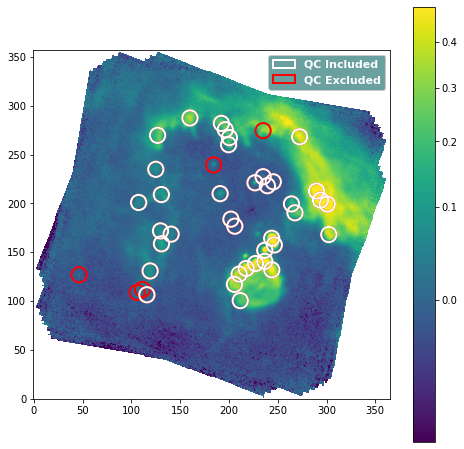

In [87]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

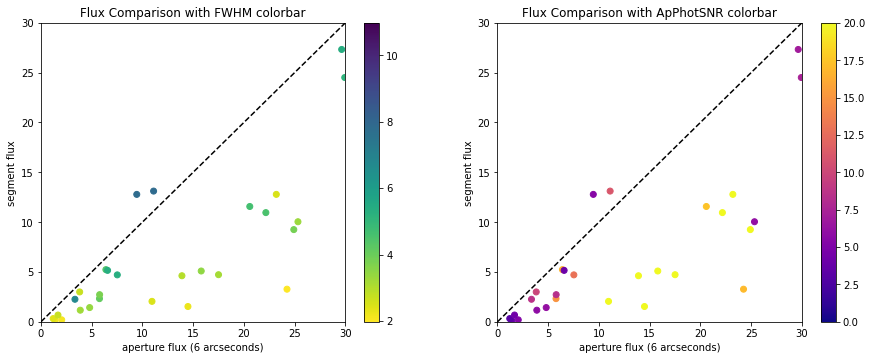

In [88]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

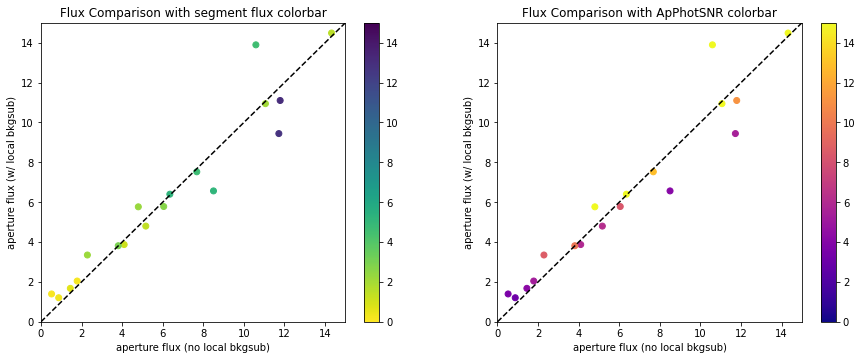

In [89]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [90]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)